In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import  Path
%pip install japanize-matplotlib
import japanize_matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [8]:
input_dir=Path("/kaggle/input/cmi-detect-behavior-with-sensor-data/")
print(list(input_dir.iterdir()))

df_tr=pd.read_csv(input_dir/"train.csv")
df_demo=pd.read_csv(input_dir/"train_demographics.csv")
print(f"train.csv shape: {df_tr.shape}")
print(f"train_demographics.csv shape: {df_demo.shape}")
df_tr.head()

[PosixPath('/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation'), PosixPath('/kaggle/input/cmi-detect-behavior-with-sensor-data/cmi-detect-behavior-with-sensor-data.zip'), PosixPath('/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv'), PosixPath('/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv'), PosixPath('/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv'), PosixPath('/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv')]
train.csv shape: (574945, 341)
train_demographics.csv shape: (81, 8)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


# 被験者(subject)ごとの分析

In [9]:
# 被験者数と基本情報
print(f"ユニークな被験者数: {df_tr['subject'].nunique()}")
print(f"被験者ID一覧: {sorted(df_tr['subject'].unique())[:20]}...")

# 被験者ごとのシーケンス数
subject_sequence_count = df_tr.groupby('subject')['sequence_id'].nunique().reset_index()
subject_sequence_count.columns = ['subject', 'sequence_count']
print(f"\n被験者ごとのシーケンス数の統計:")
print(subject_sequence_count['sequence_count'].describe())

ユニークな被験者数: 81
被験者ID一覧: ['SUBJ_000206', 'SUBJ_001430', 'SUBJ_002923', 'SUBJ_003328', 'SUBJ_004117', 'SUBJ_008304', 'SUBJ_008728', 'SUBJ_011323', 'SUBJ_012088', 'SUBJ_013623', 'SUBJ_016552', 'SUBJ_017170', 'SUBJ_017499', 'SUBJ_017807', 'SUBJ_019262', 'SUBJ_019297', 'SUBJ_019663', 'SUBJ_019756', 'SUBJ_020948', 'SUBJ_021670']...

被験者ごとのシーケンス数の統計:
count     81.000000
mean     100.629630
std        7.757971
min       51.000000
25%      102.000000
50%      102.000000
75%      102.000000
max      102.000000
Name: sequence_count, dtype: float64


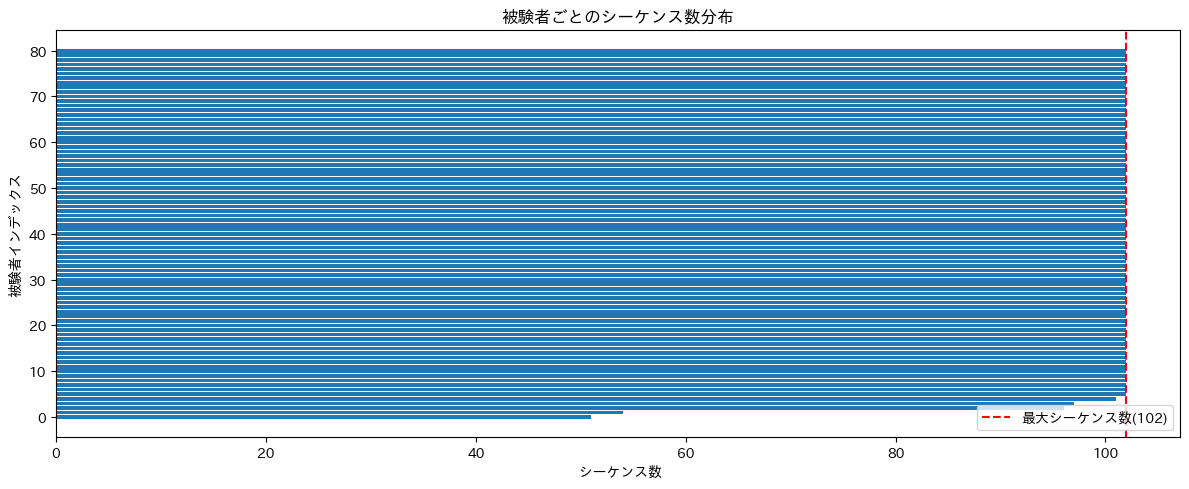

シーケンス数が100未満の被験者:
        subject  sequence_count
38  SUBJ_036405              51
64  SUBJ_053217              54
40  SUBJ_038023              96
10  SUBJ_016552              97


In [11]:
# 被験者ごとのシーケンス数の分布
fig, ax = plt.subplots(figsize=(12, 5))
subject_sequence_count_sorted = subject_sequence_count.sort_values('sequence_count')
ax.barh(range(len(subject_sequence_count_sorted)), subject_sequence_count_sorted['sequence_count'])
ax.set_xlabel(' シーケンス数')
ax.set_ylabel('被験者インデックス')
ax.set_title('被験者ごとのシーケンス数分布')
ax.axvline(x=102, color='r', linestyle='--', label='最大シーケンス数(102)')
ax.legend()
plt.tight_layout()
plt.show()

# シーケンス数が少ない被験者
print("シーケンス数が100未満の被験者:")
print(subject_sequence_count[subject_sequence_count['sequence_count'] < 100].sort_values('sequence_count'))

## 被験者のデモグラフィック情報

In [12]:
# デモグラフィックデータの確認
print("デモグラフィックデータのカラム:")
print(df_demo.columns.tolist())
print(f"\n形状: {df_demo.shape}")
df_demo.head(10)

デモグラフィックデータのカラム:
['subject', 'adult_child', 'age', 'sex', 'handedness', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']

形状: (81, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0
5,SUBJ_008304,0,16,1,1,154.0,45,22.0
6,SUBJ_008728,0,15,1,1,175.0,51,24.0
7,SUBJ_011323,1,30,0,1,175.0,71,44.0
8,SUBJ_012088,1,20,0,1,184.0,59,26.0
9,SUBJ_013623,1,36,0,0,182.0,56,28.0


In [13]:
# デモグラフィックデータの統計
print("デモグラフィックデータの統計:")
print(df_demo.describe())
print("\n欠損値:")
print(df_demo.isnull().sum())

デモグラフィックデータの統計:
       adult_child        age        sex  handedness   height_cm  \
count    81.000000  81.000000  81.000000   81.000000   81.000000   
mean      0.518519  21.814815   0.617284    0.876543  167.993827   
std       0.502770  10.289693   0.489078    0.331010   10.605863   
min       0.000000  10.000000   0.000000    0.000000  135.000000   
25%       0.000000  13.000000   0.000000    1.000000  163.000000   
50%       1.000000  22.000000   1.000000    1.000000  170.000000   
75%       1.000000  27.000000   1.000000    1.000000  174.000000   
max       1.000000  53.000000   1.000000    1.000000  190.500000   

       shoulder_to_wrist_cm  elbow_to_wrist_cm  
count             81.000000          81.000000  
mean              51.580247          25.469136  
std                4.888415           3.025254  
min               41.000000          18.000000  
25%               49.000000          24.000000  
50%               52.000000          25.000000  
75%               55.000000 

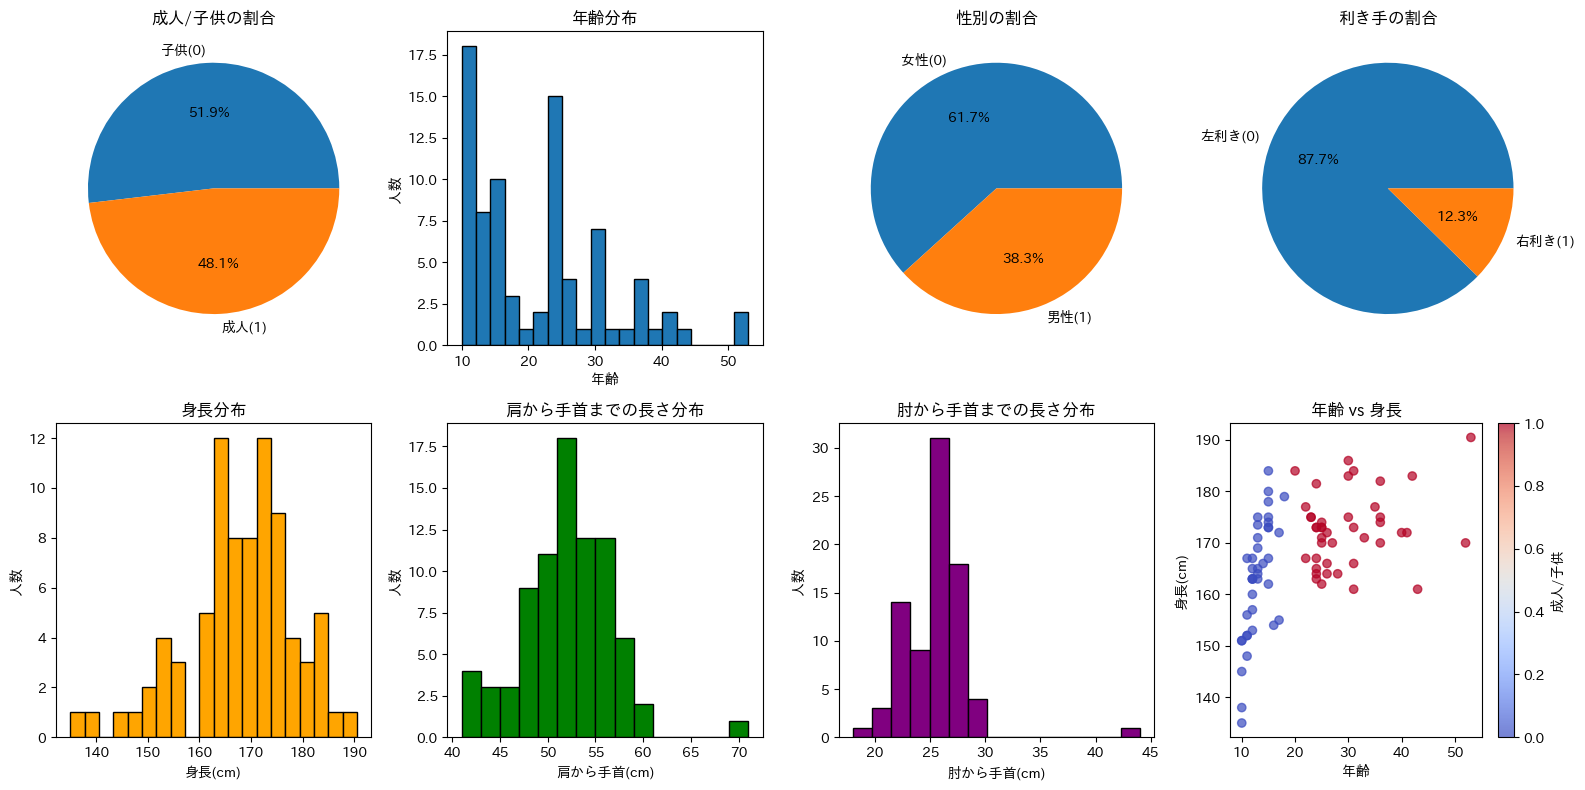

In [14]:
# デモグラフィック特徴の可視化
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# 成人/子供の分布
axes[0, 0].pie(df_demo['adult_child'].value_counts(), labels=['子供(0)', '成人(1)'], autopct='%1.1f%%')
axes[0, 0].set_title('成人/子供の割合')

# 年齢の分布
axes[0, 1].hist(df_demo['age'], bins=20, edgecolor='black')
axes[0, 1].set_xlabel('年齢')
axes[0, 1].set_ylabel('人数')
axes[0, 1].set_title('年齢分布')

# 性別の分布
axes[0, 2].pie(df_demo['sex'].value_counts(), labels=['女性(0)', '男性(1)'], autopct='%1.1f%%')
axes[0, 2].set_title('性別の割合')

# 利き手の分布
axes[0, 3].pie(df_demo['handedness'].value_counts(), labels=['左利き(0)', '右利き(1)'], autopct='%1.1f%%')
axes[0, 3].set_title('利き手の割合')

# 身長の分布
axes[1, 0].hist(df_demo['height_cm'], bins=20, edgecolor='black', color='orange')
axes[1, 0].set_xlabel('身長(cm)')
axes[1, 0].set_ylabel('人数')
axes[1, 0].set_title('身長分布')

# 肩から手首までの長さ
axes[1, 1].hist(df_demo['shoulder_to_wrist_cm'], bins=15, edgecolor='black', color='green')
axes[1, 1].set_xlabel('肩から手首(cm)')
axes[1, 1].set_ylabel('人数')
axes[1, 1].set_title('肩から手首までの長さ分布')

# 肘から手首までの長さ
axes[1, 2].hist(df_demo['elbow_to_wrist_cm'], bins=15, edgecolor='black', color='purple')
axes[1, 2].set_xlabel('肘から手首(cm)')
axes[1, 2].set_ylabel('人数')
axes[1, 2].set_title('肘から手首までの長さ分布')

# 年齢と身長の関係
scatter = axes[1, 3].scatter(df_demo['age'], df_demo['height_cm'], c=df_demo['adult_child'], cmap='coolwarm', alpha=0.7)
axes[1, 3].set_xlabel('年齢')
axes[1, 3].set_ylabel('身長(cm)')
axes[1, 3].set_title('年齢 vs 身長')
plt.colorbar(scatter, ax=axes[1, 3], label='成人/子供')

plt.tight_layout()
plt.show()

## 被験者ごとのジェスチャー分布

In [16]:
# 被験者ごとのジェスチャー種類数
subject_gesture_info = df_tr.groupby('subject').agg({
    'sequence_id': 'nunique',
    'gesture': lambda x: x.nunique(),
    'orientation': lambda x: x.nunique(),
    'sequence_type': lambda x: (x == 'Target').any()
}).reset_index()
subject_gesture_info.columns = ['subject', 'sequence_count', 'gesture_types', 'orientation_types', 'has_target']

# 全18ジェスチャーがあるか確認
print(f"全ジェスチャー種類数: {df_tr['gesture'].nunique()}")
print(f"\nジェスチャー一覧:")
for i, g in enumerate(sorted(df_tr['gesture'].unique())):
    print(f"  {i+1}. {g}")

print(f"\n被験者ごとのジェスチャー種類数の統計:")
print(subject_gesture_info['gesture_types'].describe())

全ジェスチャー種類数: 18

ジェスチャー一覧:
  1. Above ear - pull hair
  2. Cheek - pinch skin
  3. Drink from bottle/cup
  4. Eyebrow - pull hair
  5. Eyelash - pull hair
  6. Feel around in tray and pull out an object
  7. Forehead - pull hairline
  8. Forehead - scratch
  9. Glasses on/off
  10. Neck - pinch skin
  11. Neck - scratch
  12. Pinch knee/leg skin
  13. Pull air toward your face
  14. Scratch knee/leg skin
  15. Text on phone
  16. Wave hello
  17. Write name in air
  18. Write name on leg

被験者ごとのジェスチャー種類数の統計:
count    81.0
mean     18.0
std       0.0
min      18.0
25%      18.0
50%      18.0
75%      18.0
max      18.0
Name: gesture_types, dtype: float64


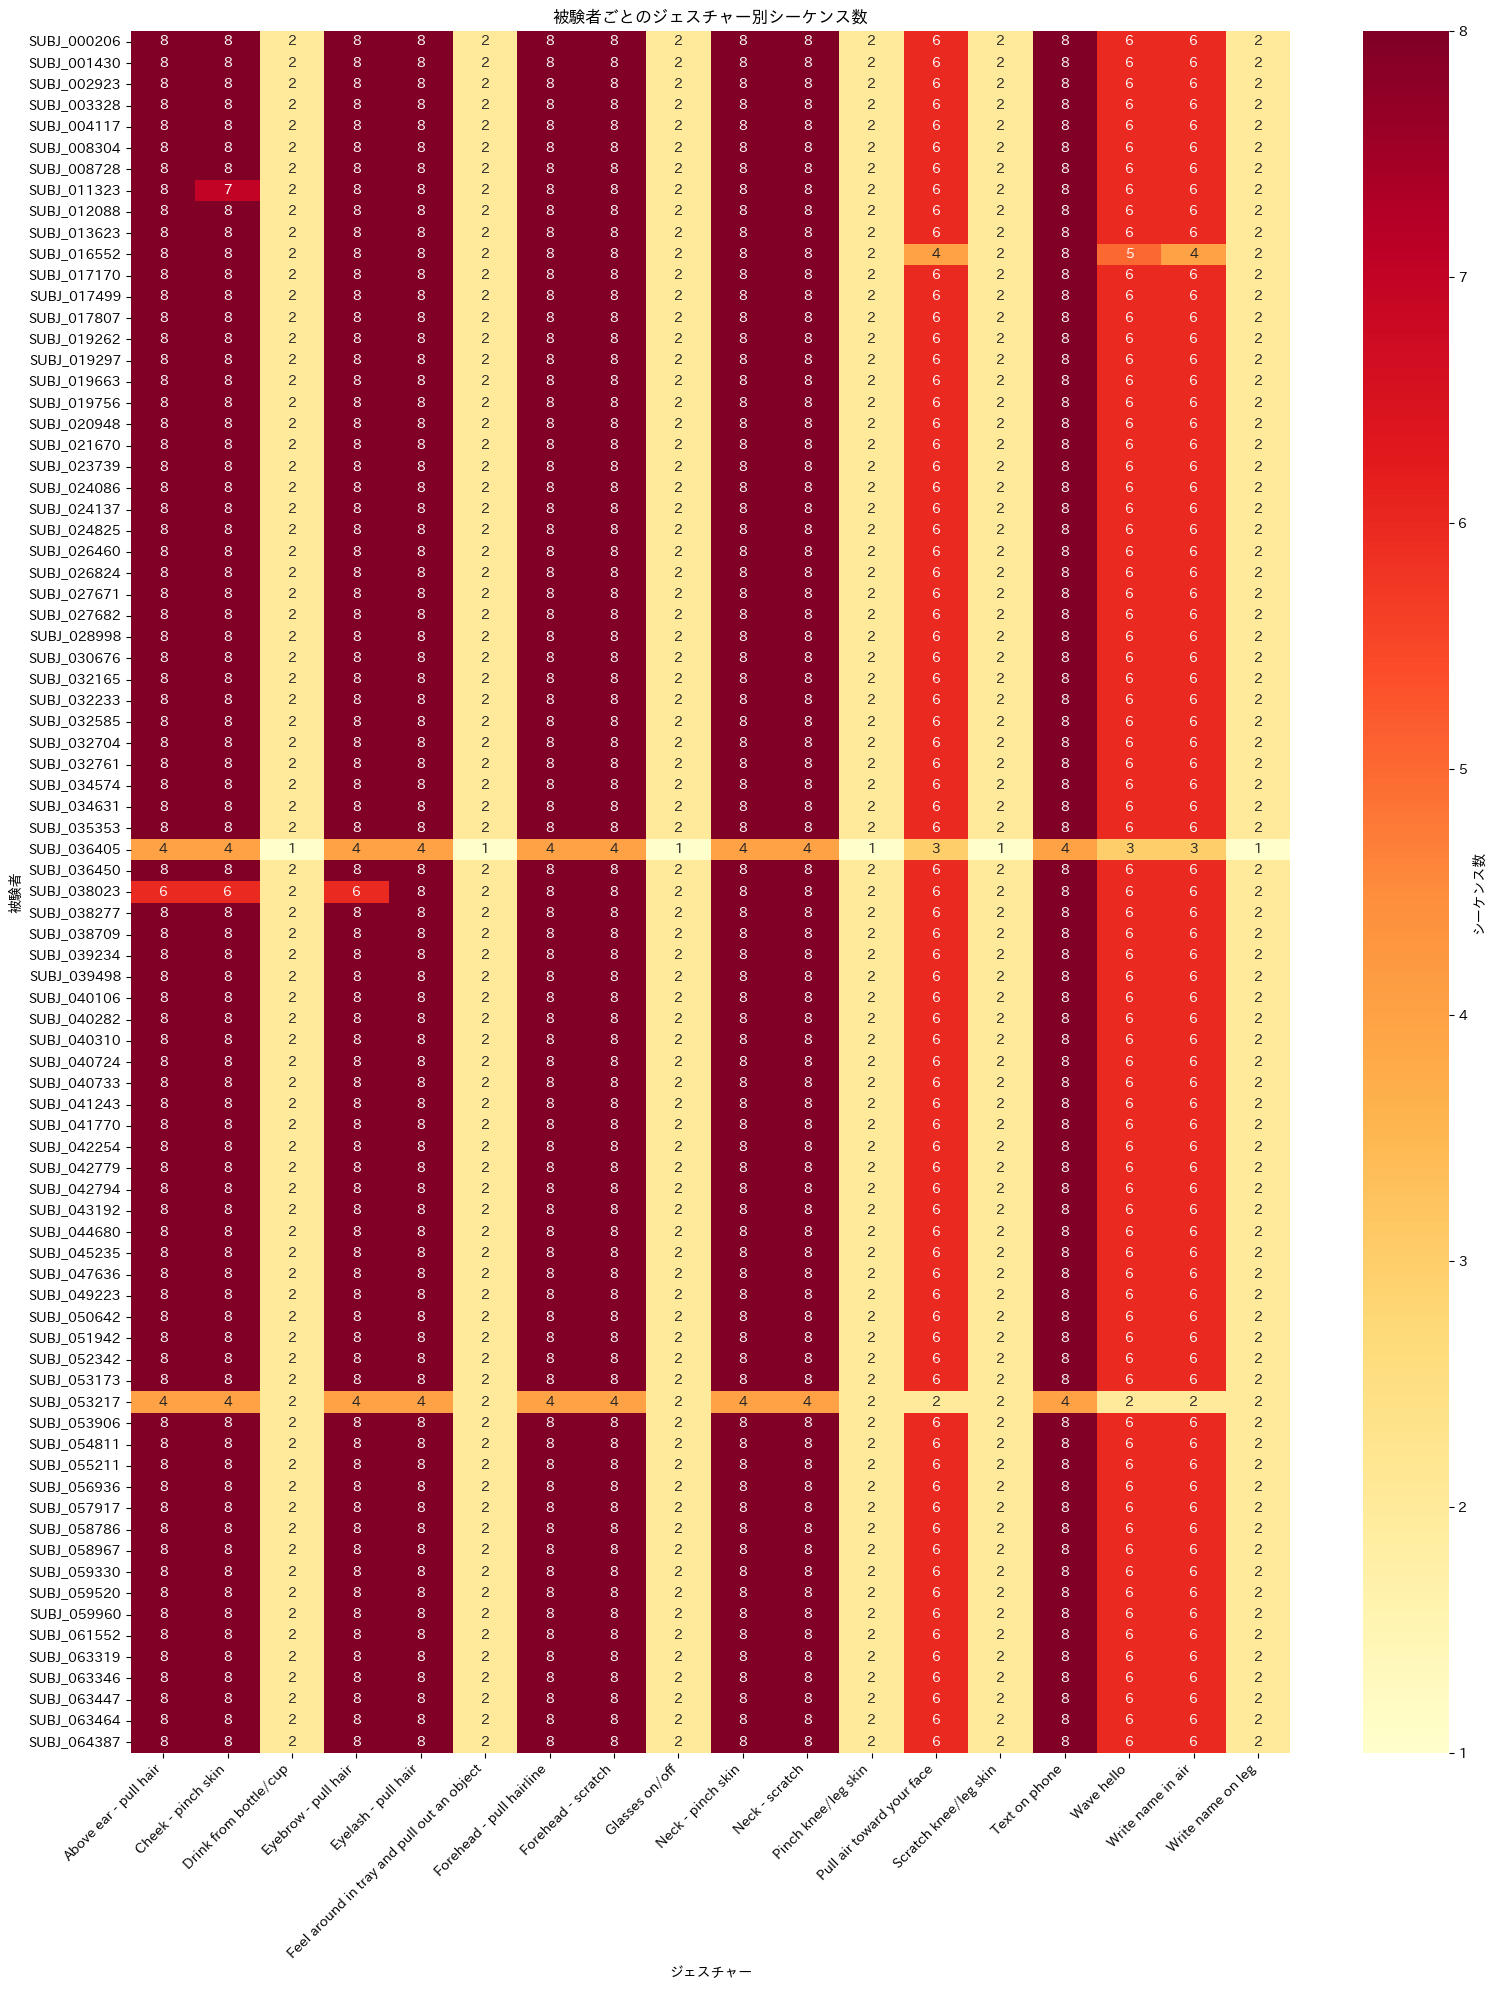


ジェスチャーごとの被験者あたりシーケンス数（平均）:
gesture
Neck - pinch skin                             7.901235
Forehead - pull hairline                      7.901235
Text on phone                                 7.901235
Neck - scratch                                7.901235
Eyelash - pull hair                           7.901235
Forehead - scratch                            7.901235
Above ear - pull hair                         7.876543
Eyebrow - pull hair                           7.876543
Cheek - pinch skin                            7.864198
Wave hello                                    5.901235
Pull air toward your face                     5.888889
Write name in air                             5.888889
Feel around in tray and pull out an object    1.987654
Glasses on/off                                1.987654
Pinch knee/leg skin                           1.987654
Scratch knee/leg skin                         1.987654
Drink from bottle/cup                         1.987654
Write name on leg            

In [18]:
# 被験者ごとのジェスチャー分布（ヒートマップ）
subject_gesture_counts = df_tr.groupby(['subject', 'gesture'])['sequence_id'].nunique().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 20))
sns.heatmap(subject_gesture_counts, cmap='YlOrRd', annot=True, fmt='d', ax=ax, cbar_kws={'label': 'シーケンス数'})
ax.set_xlabel('ジェスチャー')
ax.set_ylabel('被験者')
ax.set_title('被験者ごとのジェスチャー別シーケンス数')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 各ジェスチャーのシーケンス数統計
print("\nジェスチャーごとの被験者あたりシーケンス数（平均）:")
print(subject_gesture_counts.mean().sort_values(ascending=False))

## 被験者ごとのシーケンス長さ（タイムステップ数）

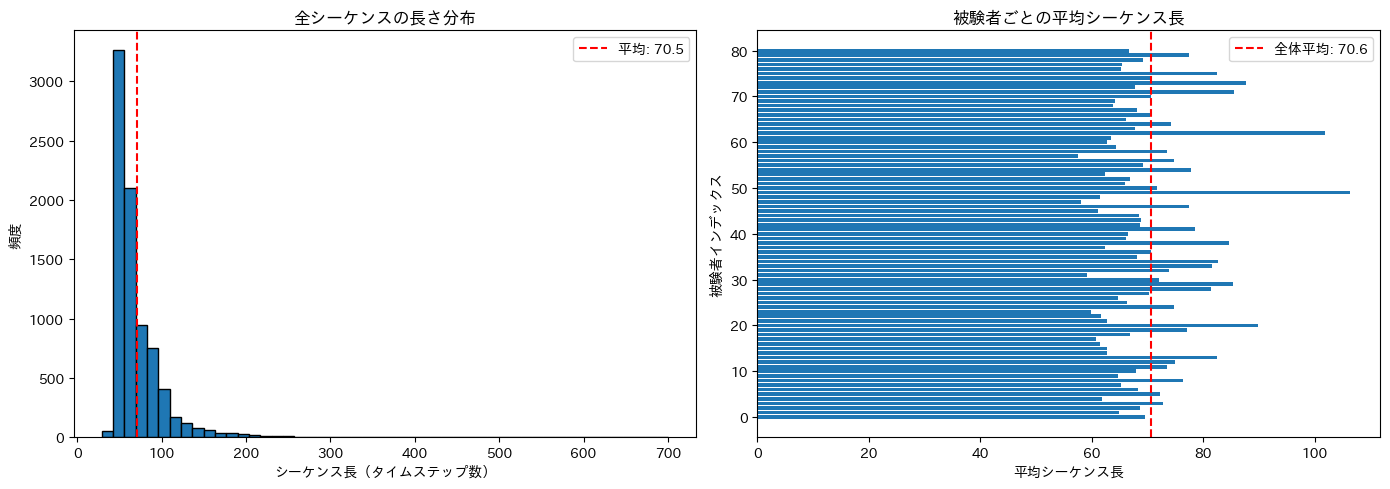


シーケンス長の統計:
全体平均: 70.5
標準偏差: 35.4
最小: 29
最大: 700


In [20]:
# 被験者ごとのシーケンス長さを分析
sequence_lengths = df_tr.groupby(['subject', 'sequence_id']).size().reset_index(name='length')

# 被験者ごとの平均シーケンス長
subject_avg_length = sequence_lengths.groupby('subject')['length'].agg(['mean', 'std', 'min', 'max']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 全体のシーケンス長分布
axes[0].hist(sequence_lengths['length'], bins=50, edgecolor='black')
axes[0].set_xlabel('シーケンス長（タイムステップ数）')
axes[0].set_ylabel('頻度')
axes[0].set_title('全シーケンスの長さ分布')
axes[0].axvline(sequence_lengths['length'].mean(), color='r', linestyle='--', label=f"平均: {sequence_lengths['length'].mean():.1f}")
axes[0].legend()

# 被験者ごとの平均シーケンス長
axes[1].barh(range(len(subject_avg_length)), subject_avg_length['mean'])
axes[1].set_xlabel('平均シーケンス長')
axes[1].set_ylabel('被験者インデックス')
axes[1].set_title('被験者ごとの平均シーケンス長')
axes[1].axvline(subject_avg_length['mean'].mean(), color='r', linestyle='--', label=f"全体平均: {subject_avg_length['mean'].mean():.1f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nシーケンス長の統計:")
print(f"全体平均: {sequence_lengths['length'].mean():.1f}")
print(f"標準偏差: {sequence_lengths['length'].std():.1f}")
print(f"最小: {sequence_lengths['length'].min()}")
print(f"最大: {sequence_lengths['length'].max()}")

## 被験者ごとのセンサーデータ特性

In [22]:
# センサーカラムの定義
imu_cols = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
thm_cols = [f'thm_{i}' for i in range(1, 6)]
tof_cols = [f'tof_{i}_v{j}' for i in range(1, 6) for j in range(64)]

print(f"IMUセンサーカラム数: {len(imu_cols)}")
print(f"Thermopileセンサーカラム数: {len(thm_cols)}")
print(f"Time-of-Flightセンサーカラム数: {len(tof_cols)}")

# 被験者ごとのIMUセンサーの統計
subject_imu_stats = df_tr.groupby('subject')[imu_cols].agg(['mean', 'std']).reset_index()
print(f"\n被験者ごとのIMUセンサー統計（サンプル）:")
print(subject_imu_stats.head())

IMUセンサーカラム数: 7
Thermopileセンサーカラム数: 5
Time-of-Flightセンサーカラム数: 320

被験者ごとのIMUセンサー統計（サンプル）:
       subject     acc_x               acc_y               acc_z            \
                    mean       std      mean       std      mean       std   
0  SUBJ_000206  2.462581  5.704739  1.946169  5.094103 -0.841174  5.680752   
1  SUBJ_001430  1.085111  5.593914  1.978724  4.988967 -1.263647  6.255139   
2  SUBJ_002923 -1.652911  4.657032  2.946610  5.233579  0.148979  6.230740   
3  SUBJ_003328  2.629071  5.729539  0.918555  5.537311 -0.292243  5.614971   
4  SUBJ_004117  2.414118  5.804902  2.150061  4.444915 -1.529596  5.923619   

      rot_w               rot_x               rot_y               rot_z  \
       mean       std      mean       std      mean       std      mean   
0  0.346818  0.192036 -0.195781  0.424807 -0.081153  0.568982 -0.193105   
1  0.345290  0.207463 -0.124513  0.467404  0.006596  0.579153 -0.172402   
2  0.389928  0.197524  0.327508  0.438982 -0.201350  0.395970 -0

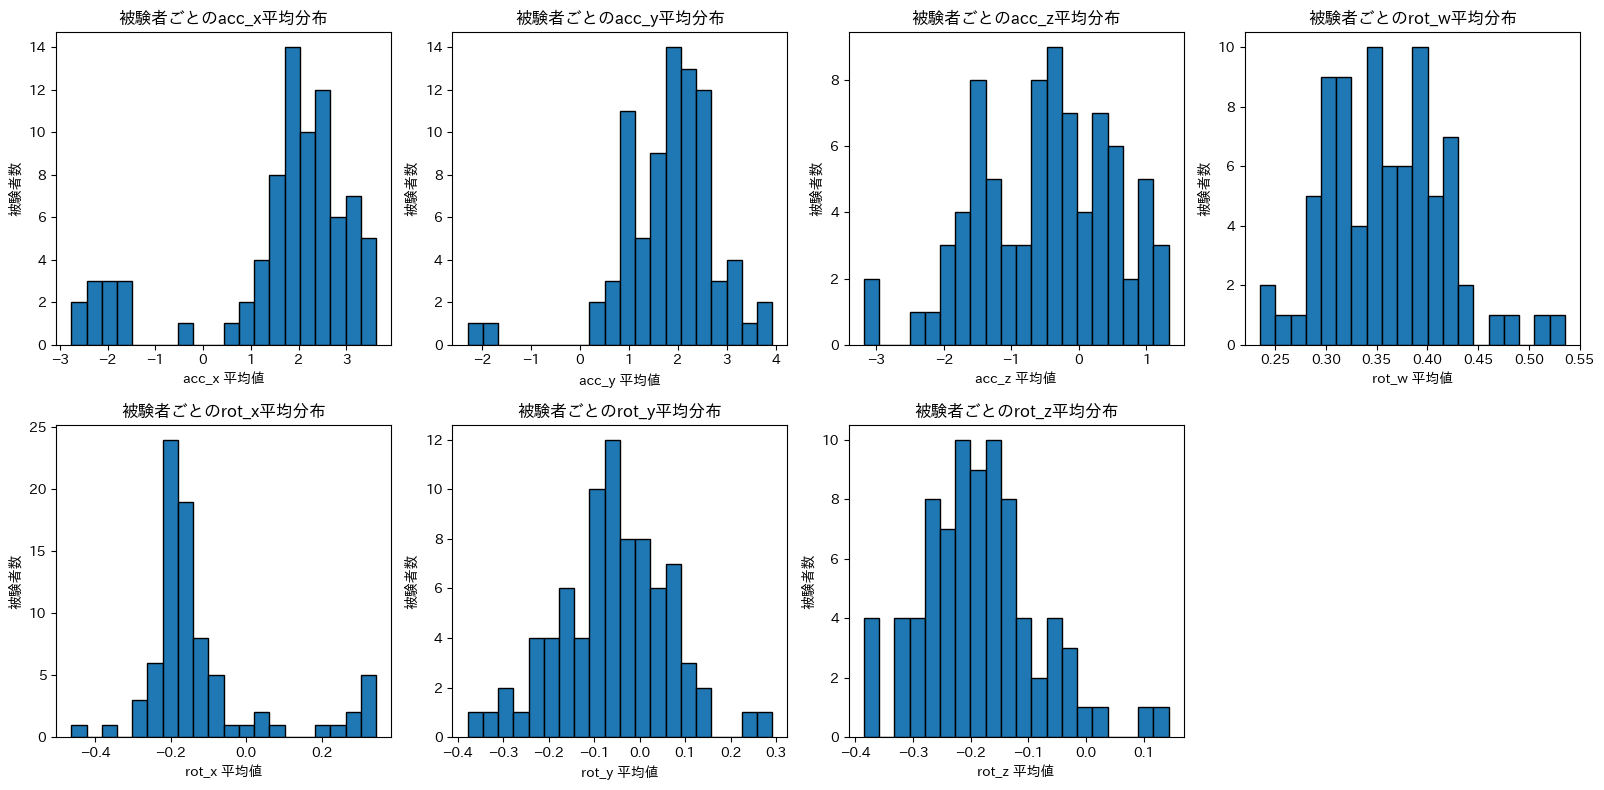

In [23]:
# 被験者ごとのIMUセンサー平均値の分布
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, col in enumerate(imu_cols):
    row, c = divmod(idx, 4)
    subject_means = df_tr.groupby('subject')[col].mean()
    axes[row, c].hist(subject_means, bins=20, edgecolor='black')
    axes[row, c].set_xlabel(f'{col} 平均値')
    axes[row, c].set_ylabel('被験者数')
    axes[row, c].set_title(f'被験者ごとの{col}平均分布')

# 最後のサブプロットは空なので非表示
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

## 被験者ごとのセンサー欠損状況

In [ ]:
# 被験者ごとのセンサー欠損率
# Thermopileセンサーの欠損率
thm_missing = df_tr.groupby('subject')[thm_cols].apply(lambda x: x.isnull().mean().mean()).reset_index()
thm_missing.columns = ['subject', 'thm_missing_rate']

# ToFセンサーの欠損率（一部のカラムでサンプリング）
tof_sample_cols = [f'tof_{i}_v0' for i in range(1, 6)]  # 各ToFセンサーの最初のピクセルのみ
tof_missing = df_tr.groupby('subject')[tof_sample_cols].apply(lambda x: x.isnull().mean().mean()).reset_index()
tof_missing.columns = ['subject', 'tof_missing_rate']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(range(len(thm_missing)), thm_missing['thm_missing_rate'] * 100)
axes[0].set_xlabel('欠損率 (%)')
axes[0].set_ylabel('被験者インデックス')
axes[0].set_title('被験者ごとのThermopileセンサー欠損率')

axes[1].barh(range(len(tof_missing)), tof_missing['tof_missing_rate'] * 100)
axes[1].set_xlabel('欠損率 (%)')
axes[1].set_ylabel('被験者インデックス')
axes[1].set_title('被験者ごとのTime-of-Flightセンサー欠損率')

plt.tight_layout()
plt.show()

print(f"\nThermopile欠損率の統計: 平均{thm_missing['thm_missing_rate'].mean()*100:.2f}%, 最大{thm_missing['thm_missing_rate'].max()*100:.2f}%")
print(f"ToF欠損率の統計: 平均{tof_missing['tof_missing_rate'].mean()*100:.2f}%, 最大{tof_missing['tof_missing_rate'].max()*100:.2f}%")

## 利き手の違いによるIMUデータ比較

In [24]:
# 利き手ごとの被験者を取得
left_handed = df_demo[df_demo['handedness'] == 0]['subject'].tolist()  # 左利き
right_handed = df_demo[df_demo['handedness'] == 1]['subject'].tolist()  # 右利き

print(f"左利き被験者数: {len(left_handed)}")
print(f"右利き被験者数: {len(right_handed)}")
print(f"左利き被験者: {left_handed}")

# 比較用のジェスチャーを選択（3つ）
gestures_to_compare = ['Above ear - pull hair', 'Cheek - pinch skin', 'Forehead - scratch']

# IMUカラム
imu_cols = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']

# behaviorのカテゴリカルマッピング
behavior_map = {'Transition': 0, 'Pause': 1, 'Gesture': 2}

左利き被験者数: 10
右利き被験者数: 71
左利き被験者: ['SUBJ_002923', 'SUBJ_013623', 'SUBJ_019756', 'SUBJ_028998', 'SUBJ_032233', 'SUBJ_032585', 'SUBJ_039234', 'SUBJ_041243', 'SUBJ_055211', 'SUBJ_061552']


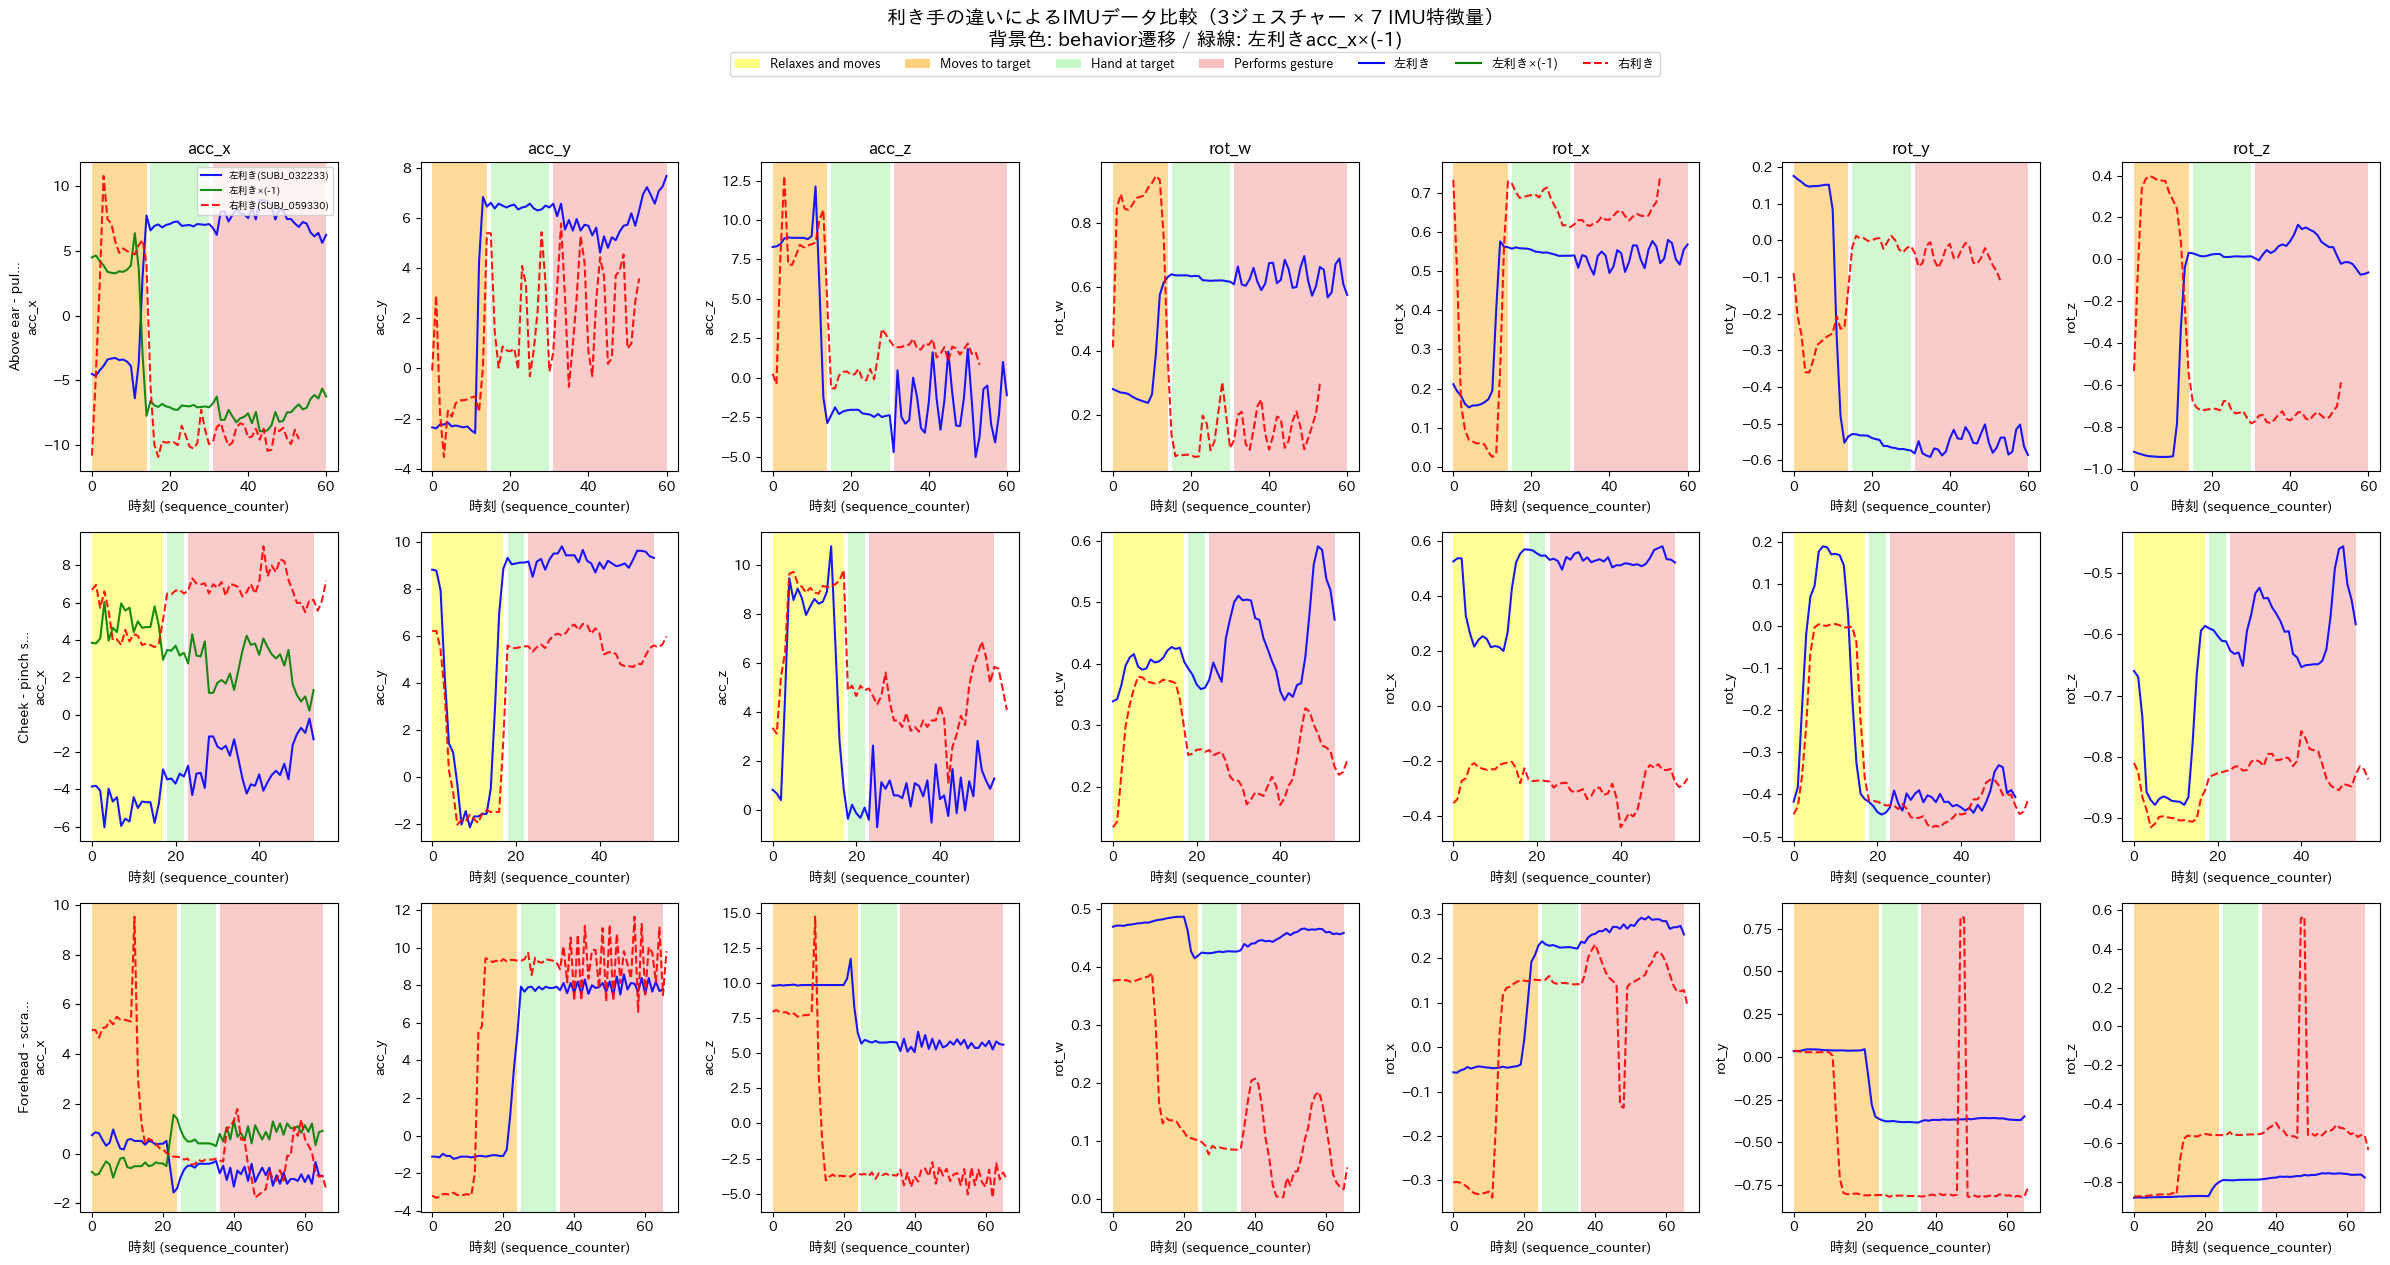

In [32]:
# behaviorの色マッピング（4種類）
behavior_colors = {
    'Relaxes and moves hand to target location': 'yellow',   # リラックスして移動
    'Moves hand to target location': 'orange',               # 移動中
    'Hand at target location': 'lightgreen',                 # ターゲット位置で静止
    'Performs gesture': 'lightcoral',                        # ジェスチャー実行
}

# 3つのジェスチャーについて、左利きと右利きの被験者を比較
fig, axes = plt.subplots(3, 7, figsize=(24, 12))

for gesture_idx, gesture in enumerate(gestures_to_compare):
    # 左利きの被験者から1サンプル取得
    left_data = df_tr[(df_tr['subject'].isin(left_handed)) & (df_tr['gesture'] == gesture)]
    left_seq_id = left_data['sequence_id'].unique()[0] if len(left_data) > 0 else None
    left_sample = left_data[left_data['sequence_id'] == left_seq_id].sort_values('sequence_counter')
    left_subject = left_sample['subject'].iloc[0] if len(left_sample) > 0 else "N/A"
    
    # 右利きの被験者から1サンプル取得
    right_data = df_tr[(df_tr['subject'].isin(right_handed)) & (df_tr['gesture'] == gesture)]
    right_seq_id = right_data['sequence_id'].unique()[0] if len(right_data) > 0 else None
    right_sample = right_data[right_data['sequence_id'] == right_seq_id].sort_values('sequence_counter')
    right_subject = right_sample['subject'].iloc[0] if len(right_sample) > 0 else "N/A"
    
    # 各IMUカラムについてプロット
    for col_idx, col in enumerate(imu_cols):
        ax = axes[gesture_idx, col_idx]
        
        # まずbehaviorの背景色を塗る（左利きのサンプルを基準）
        if len(left_sample) > 0:
            t_left = left_sample['sequence_counter'].values
            behaviors = left_sample['behavior'].values
            
            # behaviorごとに連続区間を検出して背景色を塗る
            i = 0
            while i < len(behaviors):
                current_behavior = behaviors[i]
                start_idx = i
                # 同じbehaviorが続く区間を探す
                while i < len(behaviors) and behaviors[i] == current_behavior:
                    i += 1
                end_idx = i - 1
                
                # 背景色を塗る
                color = behavior_colors.get(current_behavior, 'gray')
                ax.axvspan(t_left[start_idx], t_left[end_idx], alpha=0.4, color=color, linewidth=0)
            
            # IMUデータをプロット
            ax.plot(t_left, left_sample[col].values, 'b-', linewidth=1.5, alpha=0.9, label=f'左利き({left_subject})')
            
            # acc_xの場合、-1倍したものを緑で追加
            if col == 'acc_x':
                ax.plot(t_left, -1 * left_sample[col].values, 'g-', linewidth=1.5, alpha=0.9, label=f'左利き×(-1)')
        
        if len(right_sample) > 0:
            t_right = right_sample['sequence_counter'].values
            ax.plot(t_right, right_sample[col].values, 'r--', linewidth=1.5, alpha=0.9, label=f'右利き({right_subject})')
        
        ax.set_xlabel('時刻 (sequence_counter)')
        ax.set_ylabel(col)
        if col_idx == 0:
            ax.set_ylabel(f'{gesture[:15]}...\n{col}')
        if gesture_idx == 0:
            ax.set_title(col)
        if gesture_idx == 0 and col_idx == 0:
            ax.legend(loc='upper right', fontsize=7)

# 凡例用のダミープロット
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='yellow', alpha=0.5, label='Relaxes and moves'),
    Patch(facecolor='orange', alpha=0.5, label='Moves to target'),
    Patch(facecolor='lightgreen', alpha=0.5, label='Hand at target'),
    Patch(facecolor='lightcoral', alpha=0.5, label='Performs gesture'),
    Line2D([0], [0], color='b', linewidth=1.5, label='左利き'),
    Line2D([0], [0], color='g', linewidth=1.5, label='左利き×(-1)'),
    Line2D([0], [0], color='r', linestyle='--', linewidth=1.5, label='右利き'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=7, fontsize=9, bbox_to_anchor=(0.5, 1.02))

plt.suptitle('利き手の違いによるIMUデータ比較（3ジェスチャー × 7 IMU特徴量）\n背景色: behavior遷移 / 緑線: 左利きacc_x×(-1)', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

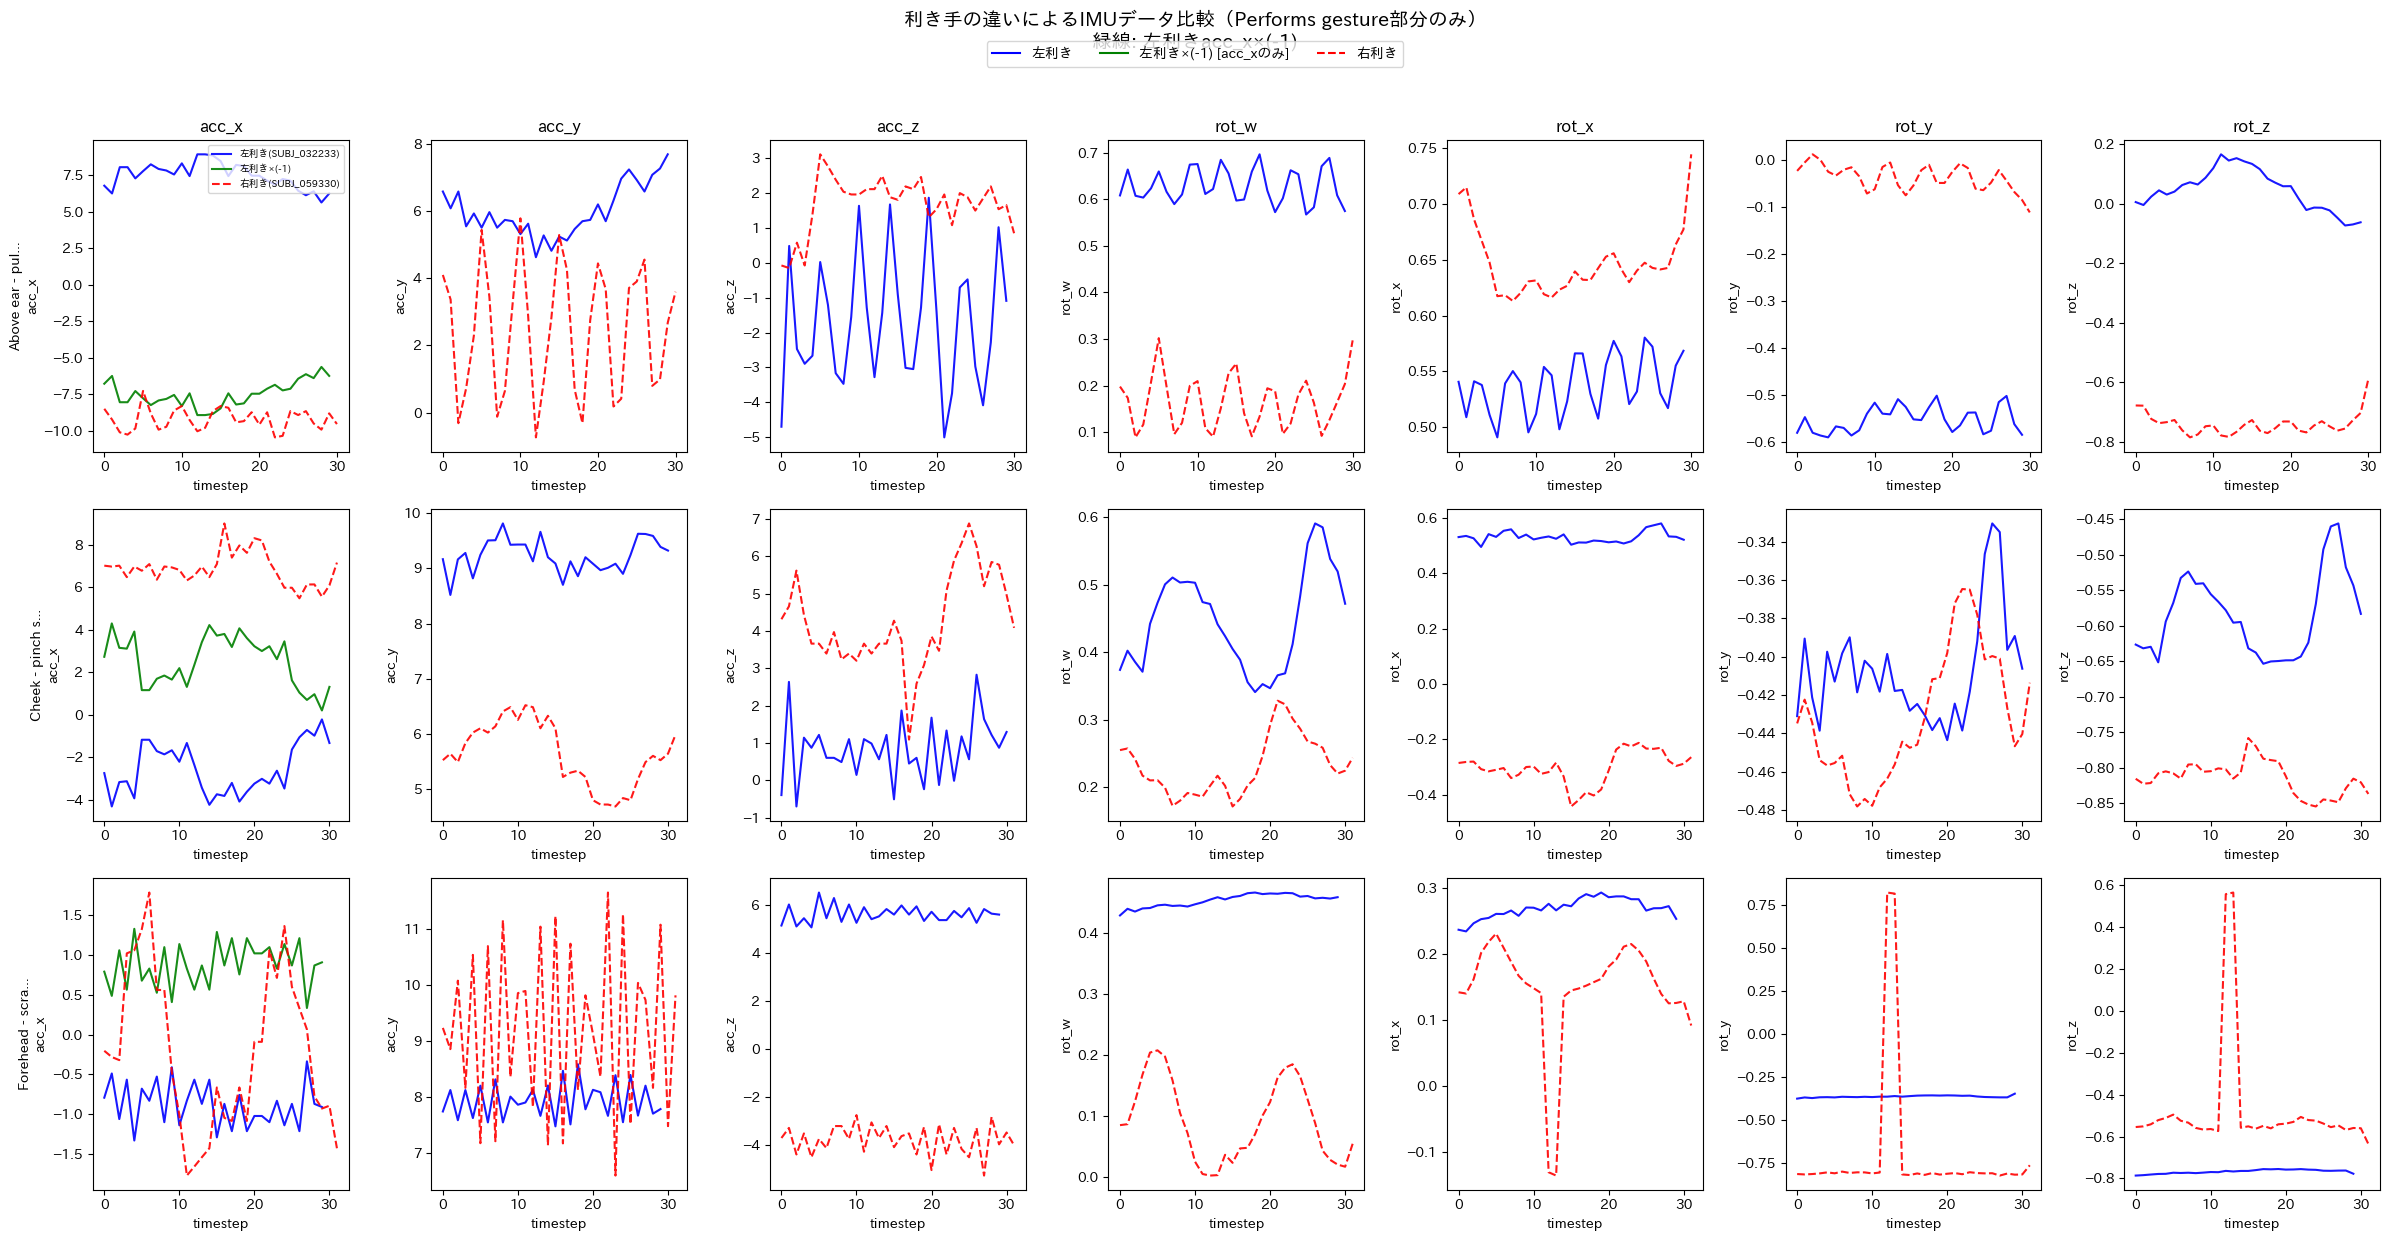

In [34]:
# Performs gesture部分のみを抽出して可視化（behaviorの色分けなし）
fig, axes = plt.subplots(3, 7, figsize=(24, 12))

for gesture_idx, gesture in enumerate(gestures_to_compare):
    # 左利きの被験者から1サンプル取得（Performs gestureのみ）
    left_data = df_tr[(df_tr['subject'].isin(left_handed)) & (df_tr['gesture'] == gesture)]
    left_seq_id = left_data['sequence_id'].unique()[0] if len(left_data) > 0 else None
    left_sample = left_data[(left_data['sequence_id'] == left_seq_id) & 
                            (left_data['behavior'] == 'Performs gesture')].sort_values('sequence_counter')
    left_subject = left_sample['subject'].iloc[0] if len(left_sample) > 0 else "N/A"
    
    # 右利きの被験者から1サンプル取得（Performs gestureのみ）
    right_data = df_tr[(df_tr['subject'].isin(right_handed)) & (df_tr['gesture'] == gesture)]
    right_seq_id = right_data['sequence_id'].unique()[0] if len(right_data) > 0 else None
    right_sample = right_data[(right_data['sequence_id'] == right_seq_id) & 
                              (right_data['behavior'] == 'Performs gesture')].sort_values('sequence_counter')
    right_subject = right_sample['subject'].iloc[0] if len(right_sample) > 0 else "N/A"
    
    # 各IMUカラムについてプロット
    for col_idx, col in enumerate(imu_cols):
        ax = axes[gesture_idx, col_idx]
        
        if len(left_sample) > 0:
            t_left = range(len(left_sample))
            ax.plot(t_left, left_sample[col].values, 'b-', linewidth=1.5, alpha=0.9, label=f'左利き({left_subject})')
            
            # acc_xの場合、-1倍したものを緑で追加
            if col == 'acc_x':
                ax.plot(t_left, -1 * left_sample[col].values, 'g-', linewidth=1.5, alpha=0.9, label=f'左利き×(-1)')
        
        if len(right_sample) > 0:
            t_right = range(len(right_sample))
            ax.plot(t_right, right_sample[col].values, 'r--', linewidth=1.5, alpha=0.9, label=f'右利き({right_subject})')
        
        ax.set_xlabel('timestep')
        ax.set_ylabel(col)
        if col_idx == 0:
            ax.set_ylabel(f'{gesture[:15]}...\n{col}')
        if gesture_idx == 0:
            ax.set_title(col)
        if gesture_idx == 0 and col_idx == 0:
            ax.legend(loc='upper right', fontsize=7)

# 凡例用
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='b', linewidth=1.5, label='左利き'),
    Line2D([0], [0], color='g', linewidth=1.5, label='左利き×(-1) [acc_xのみ]'),
    Line2D([0], [0], color='r', linestyle='--', linewidth=1.5, label='右利き'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, 1.01))

plt.suptitle('利き手の違いによるIMUデータ比較（Performs gesture部分のみ）\n緑線: 左利きacc_x×(-1)', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

比較する左利き被験者: ['SUBJ_002923', 'SUBJ_013623', 'SUBJ_019756', 'SUBJ_028998', 'SUBJ_032233']

IMUカラムの最小値・最大値:
  acc_x: min=-34.5859, max=46.3281
  acc_y: min=-24.4023, max=27.1836
  acc_z: min=-42.8555, max=30.0781
  rot_w: min=0.0000, max=0.9994
  rot_x: min=-0.9991, max=0.9998
  rot_y: min=-0.9997, max=0.9995
  rot_z: min=-0.9982, max=0.9999


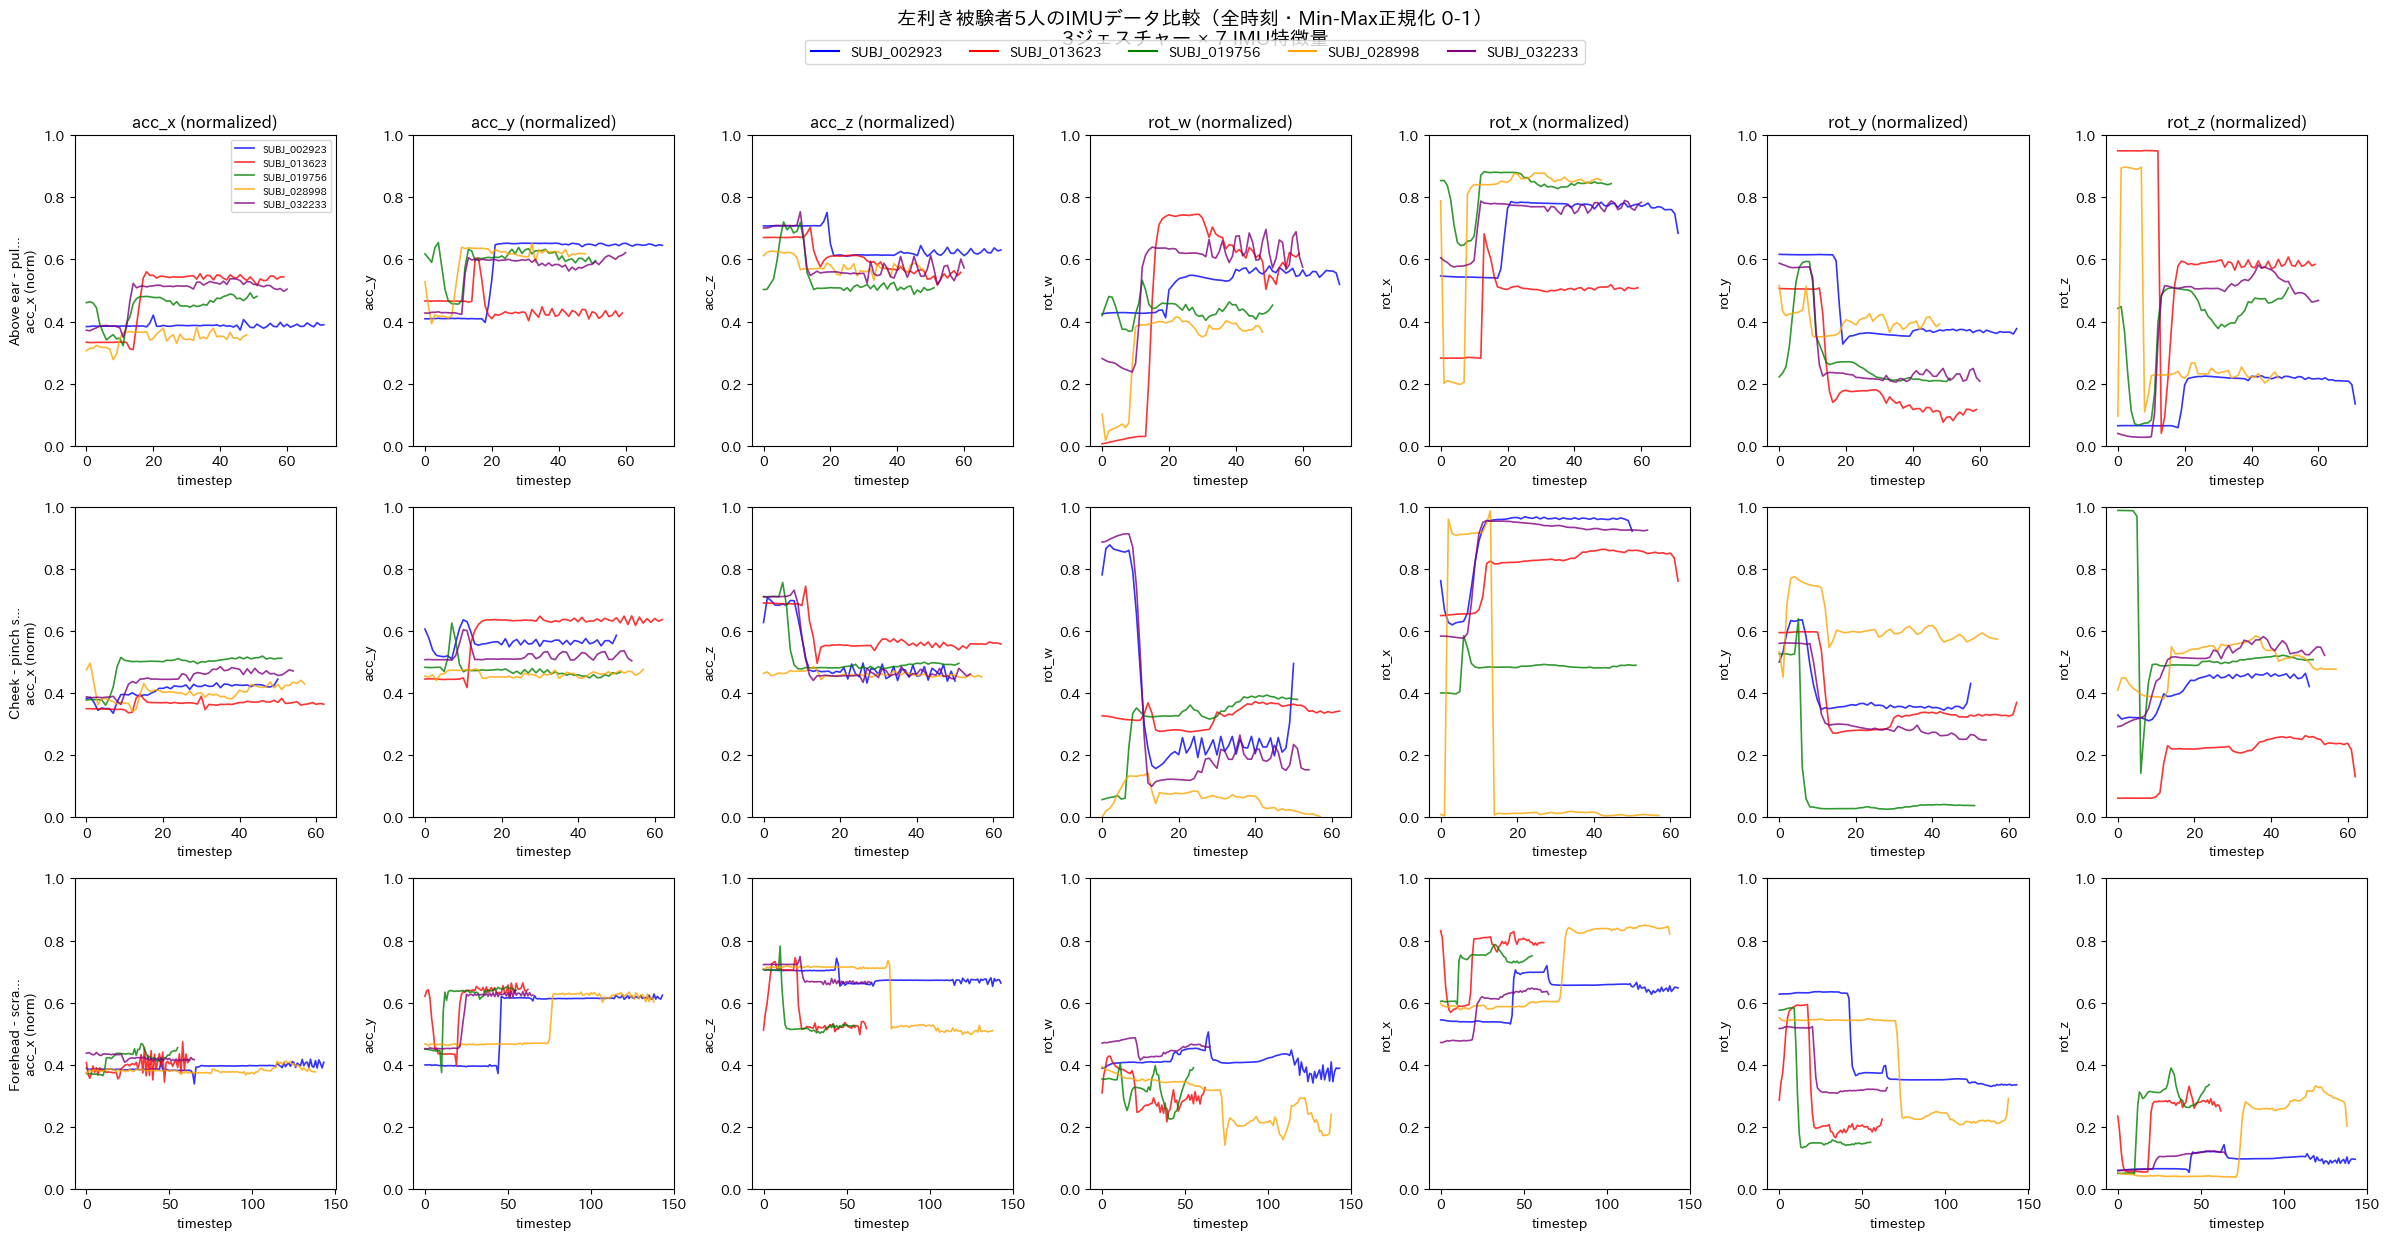

In [ ]:
# 左利き5人のデータを3つのジェスチャーについて比較（すべての時刻）
# 全データでMin-Max正規化（0-1の範囲に変換）

# 左利き被験者から5人を選択
left_handed_5 = left_handed[:5]
print(f"比較する左利き被験者: {left_handed_5}")

# 全データでの各IMUカラムのmin/maxを計算
imu_min = df_tr[imu_cols].min()
imu_max = df_tr[imu_cols].max()
print("\nIMUカラムの最小値・最大値:")
for col in imu_cols:
    print(f"  {col}: min={imu_min[col]:.4f}, max={imu_max[col]:.4f}")

# 5人の色を設定
colors = ['blue', 'red', 'green', 'orange', 'purple']

fig, axes = plt.subplots(3, 7, figsize=(24, 12))

for gesture_idx, gesture in enumerate(gestures_to_compare):
    for col_idx, col in enumerate(imu_cols):
        ax = axes[gesture_idx, col_idx]
        
        # 各左利き被験者のデータをプロット
        for subj_idx, subject in enumerate(left_handed_5):
            subj_data = df_tr[(df_tr['subject'] == subject) & (df_tr['gesture'] == gesture)]
            if len(subj_data) == 0:
                continue
            
            # 最初のシーケンスを取得
            seq_id = subj_data['sequence_id'].unique()[0]
            sample = subj_data[subj_data['sequence_id'] == seq_id].sort_values('sequence_counter')
            
            if len(sample) > 0:
                t = range(len(sample))
                # Min-Max正規化（0-1）
                normalized_values = (sample[col].values - imu_min[col]) / (imu_max[col] - imu_min[col])
                ax.plot(t, normalized_values, color=colors[subj_idx], 
                       linewidth=1.2, alpha=0.8, label=f'{subject}')
        
        ax.set_xlabel('timestep')
        ax.set_ylabel(col)
        ax.set_ylim(0, 1)  # 正規化後の範囲
        if col_idx == 0:
            ax.set_ylabel(f'{gesture[:15]}...\n{col} (norm)')
        if gesture_idx == 0:
            ax.set_title(f'{col} (normalized)')
        if gesture_idx == 0 and col_idx == 0:
            ax.legend(loc='upper right', fontsize=7)

# 凡例
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=colors[i], linewidth=1.5, label=f'{left_handed_5[i]}') 
                   for i in range(len(left_handed_5))]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, fontsize=10, bbox_to_anchor=(0.5, 1.01))

plt.suptitle('左利き被験者5人のIMUデータ比較（全時刻・Min-Max正規化 0-1）\n3ジェスチャー × 7 IMU特徴量', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

対象ジェスチャー: Above ear - pull hair
左利き被験者数: 10
右利き被験者数: 71


/tmp/ipykernel_81/1570701769.py:15: RuntimeWarning: invalid value encountered in arcsin
  pitch = np.arcsin(sinp)


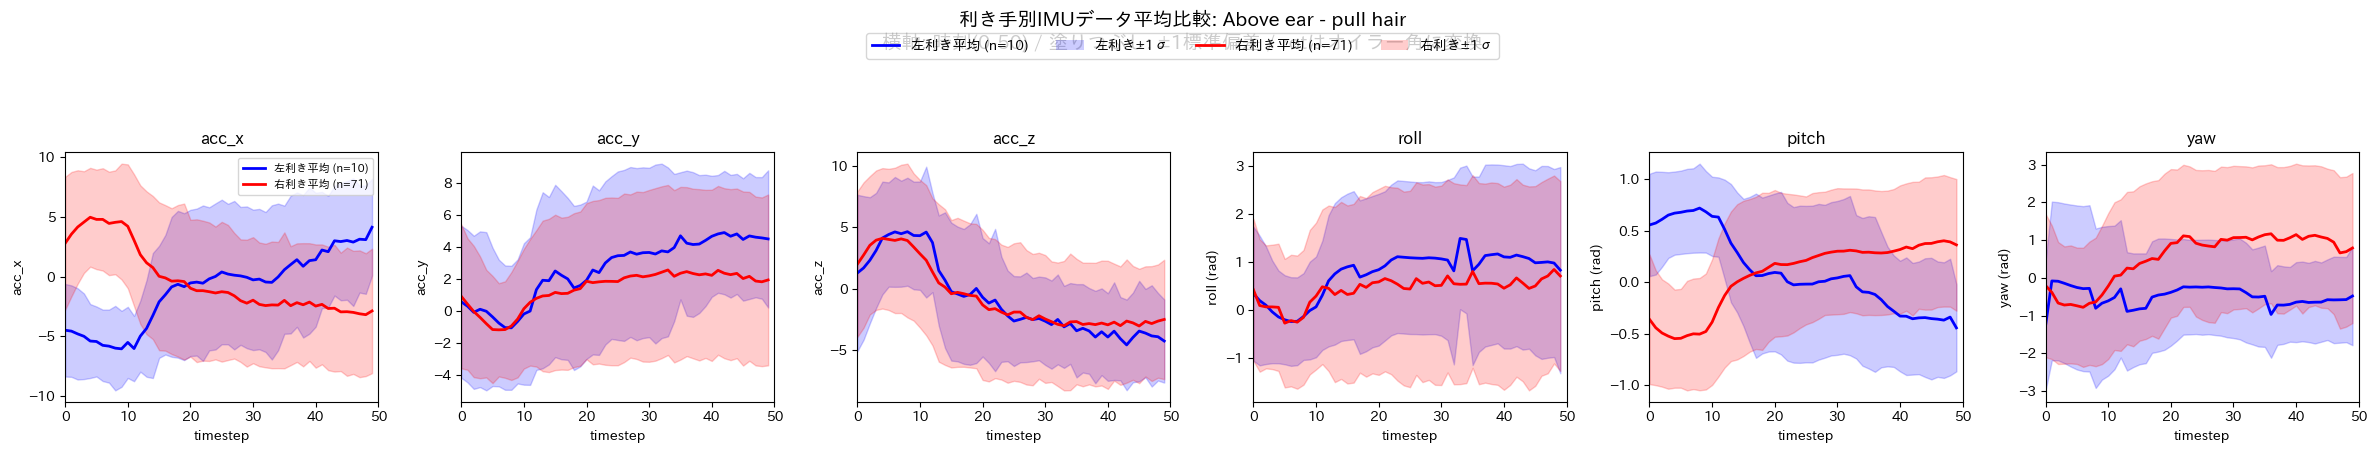

In [50]:
# クォータニオンからオイラー角への変換関数
def quaternion_to_euler(w, x, y, z):
    """
    クォータニオン (w, x, y, z) からオイラー角 (roll, pitch, yaw) に変換
    単位: ラジアン
    """
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    
    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    sinp = np.clip(sinp, -1, 1)  # 数値誤差対策
    pitch = np.arcsin(sinp)
    
    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    
    return roll, pitch, yaw

# 1つのジェスチャーに対して、左利き全員・右利き全員の平均IMUデータ比較
# 横軸: 時刻（0-Tで統一）、縦軸: 生の値（正規化なし）
# rotをオイラー角に変換
T = 50

# 対象ジェスチャー
target_gesture = 'Above ear - pull hair'
print(f"対象ジェスチャー: {target_gesture}")
print(f"左利き被験者数: {len(left_handed)}")
print(f"右利き被験者数: {len(right_handed)}")

# 描画するカラム（acc + オイラー角）
plot_cols = ['acc_x', 'acc_y', 'acc_z', 'roll', 'pitch', 'yaw']

fig, axes = plt.subplots(1, 6, figsize=(24, 4))

for col_idx, col in enumerate(plot_cols):
    ax = axes[col_idx]
    
    # 左利き全員のデータを収集して平均を計算
    left_all_values = []
    for subject in left_handed:
        subj_data = df_tr[(df_tr['subject'] == subject) & (df_tr['gesture'] == target_gesture)]
        if len(subj_data) == 0:
            continue
        
        seq_id = subj_data['sequence_id'].unique()[0]
        sample = subj_data[subj_data['sequence_id'] == seq_id].sort_values('sequence_counter')
        
        if len(sample) > 0:
            if col in ['acc_x', 'acc_y', 'acc_z']:
                values = sample[col].values[:T]
            else:
                # オイラー角を計算
                w = sample['rot_w'].values[:T]
                x = sample['rot_x'].values[:T]
                y = sample['rot_y'].values[:T]
                z = sample['rot_z'].values[:T]
                roll, pitch, yaw = quaternion_to_euler(w, x, y, z)
                if col == 'roll':
                    values = roll
                elif col == 'pitch':
                    values = pitch
                else:  # yaw
                    values = yaw
            
            # Tに満たない場合はNaNでパディング
            if len(values) < T:
                padded = np.full(T, np.nan)
                padded[:len(values)] = values
                values = padded
            left_all_values.append(values)
    
    # 右利き全員のデータを収集して平均を計算
    right_all_values = []
    for subject in right_handed:
        subj_data = df_tr[(df_tr['subject'] == subject) & (df_tr['gesture'] == target_gesture)]
        if len(subj_data) == 0:
            continue
        
        seq_id = subj_data['sequence_id'].unique()[0]
        sample = subj_data[subj_data['sequence_id'] == seq_id].sort_values('sequence_counter')
        
        if len(sample) > 0:
            if col in ['acc_x', 'acc_y', 'acc_z']:
                values = sample[col].values[:T]
            else:
                # オイラー角を計算
                w = sample['rot_w'].values[:T]
                x = sample['rot_x'].values[:T]
                y = sample['rot_y'].values[:T]
                z = sample['rot_z'].values[:T]
                roll, pitch, yaw = quaternion_to_euler(w, x, y, z)
                if col == 'roll':
                    values = roll
                elif col == 'pitch':
                    values = pitch
                else:  # yaw
                    values = yaw
            
            # Tに満たない場合はNaNでパディング
            if len(values) < T:
                padded = np.full(T, np.nan)
                padded[:len(values)] = values
                values = padded
            right_all_values.append(values)
    
    # 平均と標準偏差を計算
    if len(left_all_values) > 0:
        left_array = np.array(left_all_values)
        left_mean = np.nanmean(left_array, axis=0)
        left_std = np.nanstd(left_array, axis=0)
        t = range(T)
        ax.plot(t, left_mean, 'b-', linewidth=2, label=f'左利き平均 (n={len(left_all_values)})')
        ax.fill_between(t, left_mean - left_std, left_mean + left_std, color='blue', alpha=0.2)
    
    if len(right_all_values) > 0:
        right_array = np.array(right_all_values)
        right_mean = np.nanmean(right_array, axis=0)
        right_std = np.nanstd(right_array, axis=0)
        t = range(T)
        ax.plot(t, right_mean, 'r-', linewidth=2, label=f'右利き平均 (n={len(right_all_values)})')
        ax.fill_between(t, right_mean - right_std, right_mean + right_std, color='red', alpha=0.2)
    
    ax.set_xlim(0, T)
    ax.set_xlabel('timestep')
    if col in ['roll', 'pitch', 'yaw']:
        ax.set_ylabel(f'{col} (rad)')
    else:
        ax.set_ylabel(col)
    ax.set_title(f'{col}')
    if col_idx == 0:
        ax.legend(loc='upper right', fontsize=8)

# 凡例
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
    Line2D([0], [0], color='blue', linewidth=2, label=f'左利き平均 (n={len(left_handed)})'),
    Patch(facecolor='blue', alpha=0.2, label='左利き±1σ'),
    Line2D([0], [0], color='red', linewidth=2, label=f'右利き平均 (n={len(right_handed)})'),
    Patch(facecolor='red', alpha=0.2, label='右利き±1σ'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, fontsize=10, bbox_to_anchor=(0.5, 1.08))

plt.suptitle(f'利き手別IMUデータ平均比較: {target_gesture}\n横軸: 時刻(0-{T}) / 塗りつぶし: ±1標準偏差 / rotはオイラー角に変換', fontsize=14, y=1.12)
plt.tight_layout()
plt.show()